Inspired by code provided by Bastian Alexander Grossenbacher for the Machine Learning Lecture at UNIFR

In [114]:
from pathlib import Path
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [70]:
project_root = Path().resolve().parents[0]
train_data_path = project_root / "data" / "fashion_mnist" / "train"
test_data_path = project_root / "data" / "fashion_mnist" / "test"

In [105]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

images, _ = next(iter(loader))
mean = images.mean()
std = images.std()

print(f"Mean: {mean.item():.4f}, Std: {std.item():.4f}")

Mean: 0.2860, Std: 0.3530


In [106]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

dataset = datasets.ImageFolder(
    root=train_data_path,
    transform=transform
)

generator = torch.Generator().manual_seed(42)

# keep_fraction = 0.3
# keep_size = int(keep_fraction * len(dataset))
# discard_size = len(dataset) - keep_size
# dataset, _ = random_split(dataset, [keep_size, discard_size], generator=generator)

# Set split sizes (adjust ratio as needed)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(dataset, [train_size, val_size], generator=generator)
print("Full dataset size:", len(dataset))
print("Train subset size:", len(train_subset))
print("Val subset size:", len(val_subset))

Full dataset size: 60000
Train subset size: 48000
Val subset size: 12000


In [107]:
class FashionCNN(nn.Module):
    def __init__(self, num_channels=1, num_classes=10):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(
                in_channels=num_channels,
                out_channels=32,
                kernel_size=2,
                stride=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=2,
                stride=1,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),


            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=3, stride=1
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(1),
            nn.Dropout(),
            nn.LazyLinear(num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [108]:
def train(model, train_loader, val_loader, learning_rate=0.01, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            scores = model(data)
            loss = criterion(scores, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = scores.argmax(1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_acc = 100.0 * correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_data, val_targets in val_loader:
                val_data, val_targets = val_data.to(device), val_targets.to(device)
                val_scores = model(val_data)
                loss = criterion(val_scores, val_targets)
                val_loss += loss.item()
                val_pred = val_scores.argmax(1)
                val_correct += (val_pred == val_targets).sum().item()
                val_total += val_targets.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100.0 * val_correct / val_total

        # Logging
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%"
        )

    return train_losses, val_losses, train_accuracies, val_accuracies

In [109]:
def plot_and_save(train_losses, val_losses, train_accuracies, val_accuracies):
    os.makedirs('plots', exist_ok=True)
    epochs = range(1, len(train_losses) + 1)
    save_path = Path('plots/plot.png').parent

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training vs Validation Accuracy")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"📊 Plots saved to: {save_path}")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.001
batch_size = 128
epochs = 25


train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle= True)
val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle= True)

model = FashionCNN().to(device)
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, epochs= epochs)
plot_and_save(train_losses, val_losses, train_accuracies, val_accuracies)

Epoch [1/25] Train Loss: 0.6470, Train Acc: 80.95% | Val Loss: 0.3250, Val Acc: 88.32%
Epoch [2/25] Train Loss: 0.3517, Train Acc: 87.26% | Val Loss: 0.3012, Val Acc: 89.13%
Epoch [3/25] Train Loss: 0.3112, Train Acc: 88.72% | Val Loss: 0.2853, Val Acc: 89.65%
Epoch [4/25] Train Loss: 0.2936, Train Acc: 89.38% | Val Loss: 0.2566, Val Acc: 91.04%
Epoch [5/25] Train Loss: 0.2761, Train Acc: 89.94% | Val Loss: 0.2641, Val Acc: 90.78%
Epoch [6/25] Train Loss: 0.2615, Train Acc: 90.45% | Val Loss: 0.2626, Val Acc: 90.64%
Epoch [7/25] Train Loss: 0.2574, Train Acc: 90.59% | Val Loss: 0.2517, Val Acc: 91.04%
Epoch [8/25] Train Loss: 0.2509, Train Acc: 90.81% | Val Loss: 0.2564, Val Acc: 90.95%
Epoch [9/25] Train Loss: 0.2422, Train Acc: 91.24% | Val Loss: 0.2434, Val Acc: 91.44%
Epoch [10/25] Train Loss: 0.2348, Train Acc: 91.54% | Val Loss: 0.2395, Val Acc: 91.57%
Epoch [11/25] Train Loss: 0.2313, Train Acc: 91.52% | Val Loss: 0.2455, Val Acc: 91.47%
Epoch [12/25] Train Loss: 0.2269, Train A

In [51]:
os.makedirs('models', exist_ok=True)
torch.save(model, "models/fashion_cnn_full.pth")

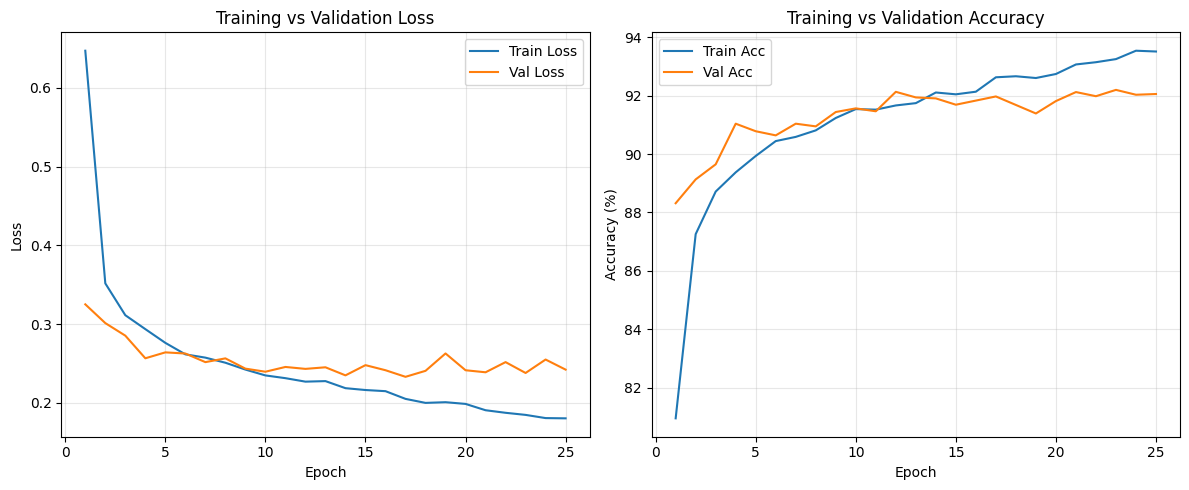

In [78]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

Image batch shape: torch.Size([10000, 1, 28, 28])
Label batch shape: torch.Size([10000])
First label: 0


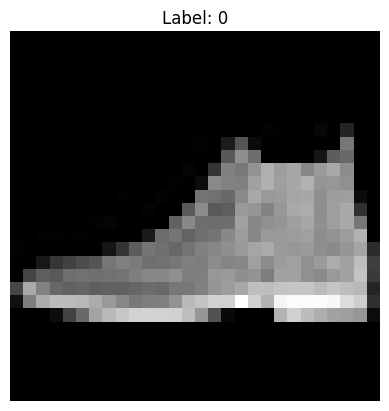

In [120]:
test_data_path = project_root / "data" / "fashion_mnist" / "test"
dataset = datasets.ImageFolder(root=test_data_path, transform=transform)
test_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

data_iter = iter(test_loader)
images, labels = next(data_iter)

print("Image batch shape:", images.shape)  # e.g. [32, 1, 28, 28]
print("Label batch shape:", labels.shape)  # e.g. [32]
print("First label:", labels[0].item())

# Show the first image
import matplotlib.pyplot as plt
plt.imshow(images[0][0].squeeze(), cmap="gray")
plt.title(f"Label: {labels[0].item()}")
plt.axis("off")
plt.show()


In [128]:
model = torch.load("models/fashion_cnn_full.pth", weights_only=False)
model.to(device)
model.eval()
predictions = []

with torch.no_grad():
     for images, _ in test_loader:  # ignore labels
        print(images.shape)
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().tolist()
        predictions.extend(preds)

torch.Size([10000, 1, 28, 28])


In [122]:
print(predictions)

[9, 2, 4, 3, 6, 3, 5, 5, 6, 0, 5, 9, 6, 3, 6, 7, 5, 1, 9, 8, 8, 9, 9, 2, 7, 7, 6, 2, 3, 8, 7, 6, 4, 5, 4, 0, 2, 6, 1, 4, 9, 3, 1, 6, 5, 0, 5, 7, 7, 5, 2, 0, 3, 9, 6, 3, 6, 0, 8, 4, 5, 0, 4, 9, 4, 6, 3, 6, 7, 5, 0, 2, 1, 1, 4, 4, 8, 5, 9, 0, 7, 1, 6, 5, 1, 4, 4, 8, 4, 7, 7, 9, 3, 8, 1, 1, 9, 8, 1, 3, 3, 7, 4, 5, 1, 5, 7, 8, 9, 6, 3, 5, 8, 5, 2, 4, 6, 3, 8, 6, 5, 5, 6, 7, 1, 5, 5, 3, 5, 4, 8, 6, 2, 1, 1, 7, 7, 9, 6, 2, 7, 0, 4, 8, 2, 2, 0, 0, 6, 4, 4, 9, 6, 8, 4, 5, 9, 6, 5, 3, 9, 6, 9, 8, 7, 4, 2, 2, 5, 2, 3, 7, 0, 7, 2, 9, 3, 7, 0, 9, 8, 4, 8, 4, 4, 7, 2, 4, 6, 2, 0, 6, 7, 8, 4, 2, 4, 5, 5, 6, 4, 5, 7, 5, 8, 1, 1, 7, 4, 0, 9, 6, 8, 8, 7, 2, 2, 1, 6, 7, 7, 4, 9, 8, 7, 0, 5, 1, 1, 0, 2, 0, 9, 0, 1, 9, 0, 0, 5, 5, 2, 0, 7, 0, 2, 3, 1, 9, 3, 1, 3, 4, 9, 2, 4, 9, 5, 2, 9, 9, 6, 3, 4, 4, 6, 0, 5, 2, 2, 3, 5, 6, 1, 4, 2, 5, 4, 4, 8, 0, 0, 2, 4, 0, 6, 2, 6, 8, 3, 8, 6, 8, 0, 4, 4, 8, 8, 4, 5, 2, 2, 3, 4, 0, 1, 9, 0, 9, 1, 9, 0, 5, 2, 1, 4, 7, 3, 8, 5, 0, 6, 6, 7, 5, 5, 5, 9, 5, 0, 6, 0, 3, 4, 

In [131]:
image_paths = [f"test/{Path(p).name}" for p, _ in dataset.samples]  # get filenames only

df = pd.DataFrame({
    "filename": image_paths,
    "prediction": predictions
})

df.to_csv("predictions.tsv", sep="\t", index=False, header=False)
print("✅ Saved predictions to predictions.tsv")

✅ Saved predictions to predictions.tsv
